In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import apogee_analysis as aah
import sys
sys.path.append("../")
from plotting_utils import fig_saver
from scipy.integrate import quad
import yields
import vice
import carbon_yield_plots as cat
import surp
import multizone_sim

../VICE/migration/src/plots/env.py:42: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]


In [3]:
AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]

In [4]:
sf = fig_saver("figures")

In [5]:
v21 = aah.vincenzo2021()

filt = ~v21["high_alpha"]
filt &= v21["[o/h]"] > -0.05
filt &= v21["[o/h]"] < 0.05
df = v21[filt]
np.mean(df["[c/o]"])

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.08713825470874835

/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


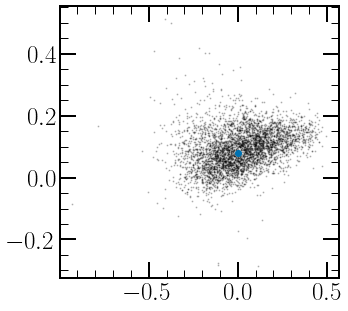

In [6]:
aah.plot_v21("[o/h]", "[c/o]")
plt.scatter(0, 0.08)

## Calculating  y_c_cc from observations

If we assume values for $y_{O, 0}^{cc}$, $f_C^{agb}$, $y_C^{agb}$, the SFH, $\dot{M}_\star(t)$, and $\eta$, we can calculate values fo $y_c^{cc}$ based on observations if we assume the observed \[C/O\]-\[O/H\] tracks are equilibrium tracks.

Let $\langle y_c^{agb} \rangle$ be the effective present day agb yield. In other words, the weigted average of $y_c^{agb}$ over the SFH and IMF:
$$
\langle y_c^{agb} \rangle = \frac{\int_0^T y_c^{agb}(M, Z) \dot{M}_\star(T - t) \frac{dN}{dM} \frac{dM}{dt} dt  }{ \dot{M}_\star \int_0^T \frac{dN}{dM} \frac{dM}{dt} dt}
$$ 

We also define $\varpi$ as the reduction factor in $y_o^{cc}$, so ${y_o^{cc}}' = \varpi y_o^{cc}$, and to keep the equilibrium yields constant
$$
\frac{\eta'}{\eta} = \kappa \frac{\varpi - 1}{\eta} + \varpi
$$
Where $\kappa = 1 - r - \tau_\star/\tau_{\rm{sfh}}$. With this adjustment, the AGB yields are effectively increased by $1/\varpi$, so a reduction to $\varpi$ increases the AGB fraction. We leave this as the only adjustment to AGB yields for a given yield set.

The equilibrium C abundance under an exponentally declining SFH, $\dot{M_g}/M_g = -1/\tau_{sfh}$, is
$$
Z_c^{eq}(R) = \frac{y_c^{cc} + \langle y_c^{agb} \rangle }{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$

$$
Z_o^{eq}(R) = \frac{y_o^{cc} }{1 + \eta(R) - r - \tau_\star / \tau_{sfh}}
$$

so
$$
\frac{Z_c^{eq}}{Z_o^{eq}} = \frac{y_c^{cc} + \langle y_c^{agb} \rangle }{y_o^{cc}}
$$

Now we can write that, given \[C/O\] as a function of Z,

$$
y_C^{cc} = \varpi y_o^{cc} \frac{Z_{C, \odot}}{Z_{O, \odot}} 10^{[C/O]} - \langle y_c^{agb} \rangle
$$

In [7]:
out = vice.output("output/analytic")
def get_value(name, i=-1):
    return np.array([out.zones["zone%i" % (int(10*j))].history[name][i] for j in R])[6:]

In [8]:
R = np.arange(3, 11, 0.1)

Z = get_value("z")
eta = get_value("eta_0")
r = get_value("r_eff")
sfr = get_value("sfr")
Mg = get_value("mgas")
dt = 0.1
Mg_dot = (Mg - get_value("mgas", i=-11))/dt
Mstar = get_value("mstar")
tau_sfh = - Mg/Mg_dot
tau_star = Mg/(sfr * 10**9)
t = out.zones["zone0"].history["time"]
dt = 0.01

MoverH = np.log10(Z/0.014)



In [9]:
def m_star(R, t):
    """Calculates the star formation rate as $\\dot{M}_\\star$
    Input: R, galacic radius
    Input t: time
    Double check this is what this actually does lol
    """
    T = int(100*t) - 1
    if type(R) in (list, np.array, tuple, np.ndarray):
        return [out.zones["zone%i" % int(i)].history["sfr"][T] for i in 10*R]
    else:
        i = int(10*R)
        return out.zones["zone%i" % int(i)].history["sfr"][T]

In [10]:
def imf(m):
    return m**-2.3

def dn_dt(t):
    return imf(m_to(t)) * (-1/35) * (t/10)**(-4.5/3.5)
    
def m_to(t):
    return (t/10)**(-1/3.5)

def t_to(m):
    return 10*m**-3.5

def t_int(f, t_f=13.2):
    return quad(f, t_to(8), t_f)[0]

def y_agb_ave(i, y_agb = None):
    """returns the time-averaged agb yield at present day, so effective y_c^{agb}"""   
    if y_agb is None:
        y_agb = vice.yields.agb.interpolator("c", study="cristallo11")
    z = Z[i]
    r = R[i]
    mdot_star = sfr[i]
    t_max = 13.2
    return t_int(lambda t: m_star(r, t_max - t) * y_agb(m_to(t), z) * dn_dt(t), t_max) /t_int(dn_dt) / mdot_star

In [11]:
y_agb_a = {}
for name in AGB_MODELS:
    y_agb = vice.yields.agb.interpolator("c", study=name)
    y_agb_a[name] = np.array([y_agb_ave(i, y_agb=y_agb) for i in range(len(Z))])


/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  


Text(0, 0.5, '$\\langle y_c^{agb}\\rangle$')

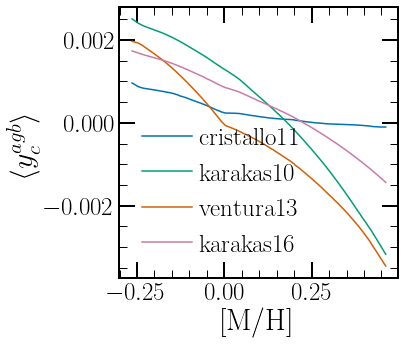

In [13]:
for name in AGB_MODELS:
    plt.plot(MoverH, y_agb_a[name], label=name)
plt.legend()
plt.xlabel("[M/H]")
plt.ylabel(r"$\langle y_c^{agb}\rangle$")
plt.ax

# now calculate y_c_cc

In [14]:
fe_h = MoverH
fe_h = np.append(fe_h, 2 * fe_h[-1] - fe_h[-2])[::-1]
bins, c_o, sds, counts = aah.calc_mean_v21("[fe/h]", "[c/o]", bins = fe_h)
err_means = sds/np.sqrt(counts)
c_o = c_o[::-1]
c_o_err = err_means[::-1]



/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '[c/o]')

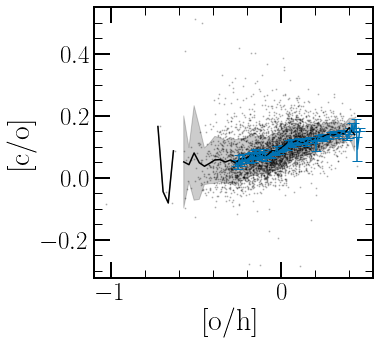

In [15]:
plt.errorbar(MoverH, c_o, yerr=c_o_err)
aah.plot_v21("[fe/h]", "[c/o]", exclude_high_alpha=True)
aah.plot_mean_v21("[fe/h]", "[c/o]");
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

# This is a digression from the notebook


In [49]:
import vice_utils

In [74]:
i0 = 50

print("R = %1.3f kpc" % R[i0])
print("[C/O] = %1.3f" % c_o[i0])
print("[FE/H] = %1.3f" % fe_h[i0])
print("eta = %1.3f" % eta[i0])
print("r = %1.3f" % r[i0])

print("C/O = %1.3f" % CO)
print("y_c = %1.5f" % (CO*0.015))


R = 8.000 kpc
[C/O] = 0.068
[FE/H] = 0.201
eta = 2.495
r = 0.449
C/O = 0.483
y_c = 0.00724


In [72]:
for name, value in y_agb_a.items():
    print("%s = %1.6f" % (name, value[i0]))

cristallo11 = 0.000451
karakas10 = 0.001633
ventura13 = 0.000562
karakas16 = 0.001112


In [7]:
for name in AGB_MODELS:
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.agb.settings["c"] = name
    m_c, times = vice.single_stellar_population("c", Z=0.014)

    print("%s = %f" % (name, m_c[-1]/10**6))

cristallo11 = 0.000347
karakas10 = 0.000585
ventura13 = 0.000060
karakas16 = 0.000421


In [87]:
y_o_cc = 0.015
y_c_cc = 0.005

def alpha_agb(alpha_cc, agb_model="cristallo11"):
    CO = aah.bracket_to_abundance(c_o[i0], "C", "O")
    return (CO*y_o_cc - y_c_cc*alpha_cc)/y_agb_a[agb_model][i0]

In [111]:
for model in AGB_MODELS:
    print(model)
    print(r"$%1.5f = %1.5f \alpha_\text{AGB} + %1.5f \alpha_\text{cc}$" % (CO*y_o_cc, y_agb_a[model][i0], y_c_cc))

cristallo11
$0.00724 = 0.00045 \alpha_\text{AGB} + 0.00500 \alpha_\text{cc}$
karakas10
$0.00724 = 0.00163 \alpha_\text{AGB} + 0.00500 \alpha_\text{cc}$
ventura13
$0.00724 = 0.00056 \alpha_\text{AGB} + 0.00500 \alpha_\text{cc}$
karakas16
$0.00724 = 0.00111 \alpha_\text{AGB} + 0.00500 \alpha_\text{cc}$


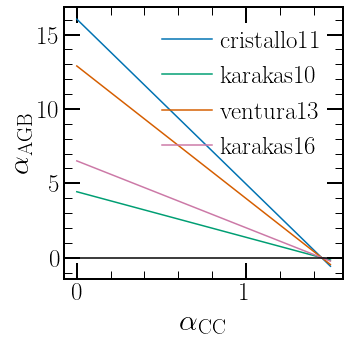

In [104]:
x = np.linspace(0, 1.5, 1000)

for name in AGB_MODELS:
    plt.plot(x, alpha_agb(x, name), label=name)
plt.axhline(0, color="k")
plt.xlabel(r"$\alpha_\text{CC}$")
plt.ylabel(r"$\alpha_\text{AGB}$")
plt.legend()

# Returning to calculation

In [16]:
# parameters
pii = 0.3
y_o_cc = 0.015

In [17]:
def calc_y_c_cc(y_agb_a, pii=1, y_o_cc=0.015):
    y_c_cc =pii*y_o_cc*aah.bracket_to_abundance(c_o, "C", "O") - y_agb_a
    y_c_cc_err = pii*y_o_cc*aah.bracket_to_abundance(c_o, "C", "O") * c_o_err
    return y_c_cc, y_c_cc_err

In [18]:
def plot_model(y_agb_a, pii=1, **kwargs):
    y_c_cc, _ = calc_y_c_cc(y_agb_a, pii)
    plt.plot(MoverH, y_c_cc/pii, label="pii = %1.2f" % pii, **kwargs)

In [33]:
def compare_y_c_cc(y_agb_a):
    pii = 1
    plot_model(y_agb_a, pii)
    y_c_cc_model = fit_model(y_agb_a, pii)(Z)
    plt.errorbar(MoverH, y_c_cc_model/pii)

    plt.xlabel("[M/H]")
    plt.ylabel("y carbon core collapse/pii")

Above, solid lines are the fitted curves and the squigly lines are the value of y_c_cc calculated at each \[M/H\]

In [20]:
def plot_f_agb(y_agb_a, pii=1):
    y_c_cc, _ = calc_y_c_cc(y_agb_a, pii)
    plt.plot(MoverH, y_agb_a/(y_c_cc+y_agb_a), label="pii = %1.2f" % pii)

In [34]:
def compare_f_agb(y_agb_a):
    plot_f_agb(y_agb_a)

    plt.xlabel("[M/H]")
    plt.ylabel("f agb")
    plt.scatter(0, 0.2, marker="*", s=200, c="orange")
    #plt.ylim(-1)


In [22]:
from scipy.optimize import curve_fit

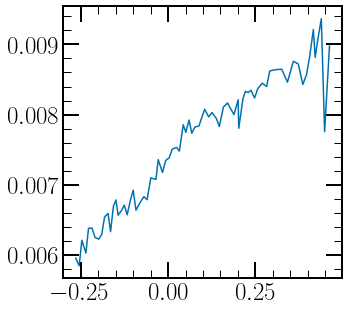

In [25]:
y_c_cc, y_c_cc_err = calc_y_c_cc(y_agb_a["cristallo11"], 1)
plt.plot(MoverH, y_c_cc)

In [35]:
def model(MoverH, a, b):
    return a*10**(b*MoverH)

def fit_model(y_agb_a, pii=1):
    y_c_cc, y_c_cc_err = calc_y_c_cc(y_agb_a, pii)
    popt, covt = curve_fit(model, MoverH, y_c_cc)# , sigma=y_c_cc_err)
    b = popt[1]
    a = popt[0]/0.014**b

    b_err = np.sqrt(covt[1][1])
    a_err = np.sqrt(covt[0][0])/0.014**b + np.log(1/0.014) * a/0.014 * covt[1][1]
    print("model: y_c^cc = (%1.4f +- %1.5f) Z^(%1.3f +- %1.4f})" % (a, a_err, b, b_err))
    def model2(Z):
        return a*Z**b
    model2.a = a
    model2.b = b
    model2.a_err = a_err
    model2.b_err = b_err
    
    return model2

In [36]:
def calc_equlibrium(y_agb_a, pii=1, y_o_cc = 0.015):
    denom = pii*(1 + eta - r - tau_star/tau_sfh)
    
    o_eq = pii*y_o_cc/denom

    c_eq = (y_agb_a + fit_model(y_agb_a, pii)(Z))/denom
    # c_eq = (y_agb_a + y_c_cc)/denom
    o_h = aah.abundance_to_bracket(o_eq, "O")
    c_h = aah.abundance_to_bracket(c_eq, "C")
    c_o = c_h - o_h
    return o_h, c_o

model: y_c^cc = (0.0192 +- 0.00052) Z^(0.229 +- 0.0085})


/users/PAS2232/aeyobd/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


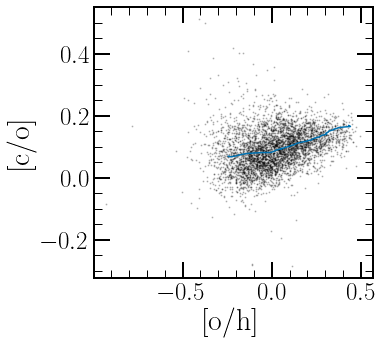

In [37]:
def compare_cooh(y_agb_a):
    plt.plot(*calc_equlibrium(y_agb_a, 1), label="1")

    aah.plot_v21("[o/h]", "[c/o]")
    plt.xlabel("[o/h]")
    plt.ylabel("[c/o]")

compare_cooh(y_agb_a["cristallo11"])

Lines are labeled by the value of $\varpi$.

model: y_c^cc = (0.0192 +- 0.00052) Z^(0.229 +- 0.0085})


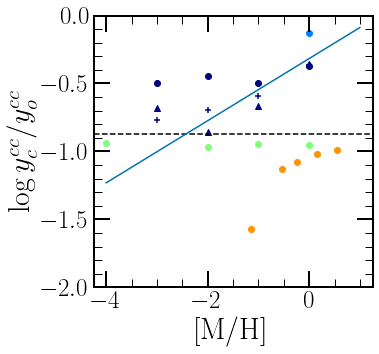

In [39]:
def compare_ycyo(y_agb_a):
    cat.plot_ycyo(scaled=False)
    x = np.linspace(-4, 1, 1000)
    y_o = 0.015

    for pii in [1]:
        ycyo = np.log10(fit_model(y_agb_a, pii)(0.014*10**x) / (pii*y_o))# - np.log10(vice.solar_z("c")/vice.solar_z("o"))
        plt.errorbar(x, ycyo, label="pii = %1.2f" % pii)

    plt.axhline(np.log10(0.002/0.015), color="k", ls="--", label="fiducial")

    # plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.ylabel("$\log y_c^{cc} / y_o^{cc}$")
    plt.ylim(-2, 0)
compare_ycyo(y_agb_a["cristallo11"])

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
def compare_agb_model(study="cristallo11", agb_factor=1):
    y = y_agb_a[study] * agb_factor
    
    plt.figure(figsize=(12,10))
    plt.subplot(2,2, 1)
    compare_y_c_cc(y)
    plt.subplot(2, 2, 2)
    compare_f_agb(y)
    plt.subplot(2, 2, 3)
    compare_cooh(y)
    plt.subplot(2, 2, 4)
    compare_ycyo(y)


model: y_c^cc = (0.0192 +- 0.00052) Z^(0.229 +- 0.0085})
model: y_c^cc = (0.0192 +- 0.00052) Z^(0.229 +- 0.0085})
model: y_c^cc = (0.0192 +- 0.00052) Z^(0.229 +- 0.0085})


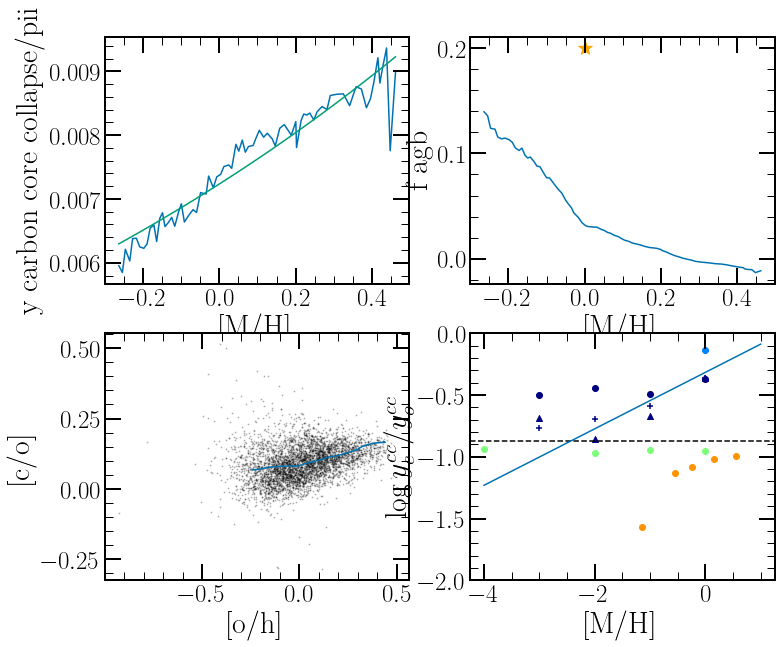

In [44]:
compare_agb_model()

model: y_c^cc = (0.1034 +- 0.05327) Z^(0.704 +- 0.0400})
model: y_c^cc = (0.1034 +- 0.05327) Z^(0.704 +- 0.0400})
model: y_c^cc = (0.1034 +- 0.05327) Z^(0.704 +- 0.0400})


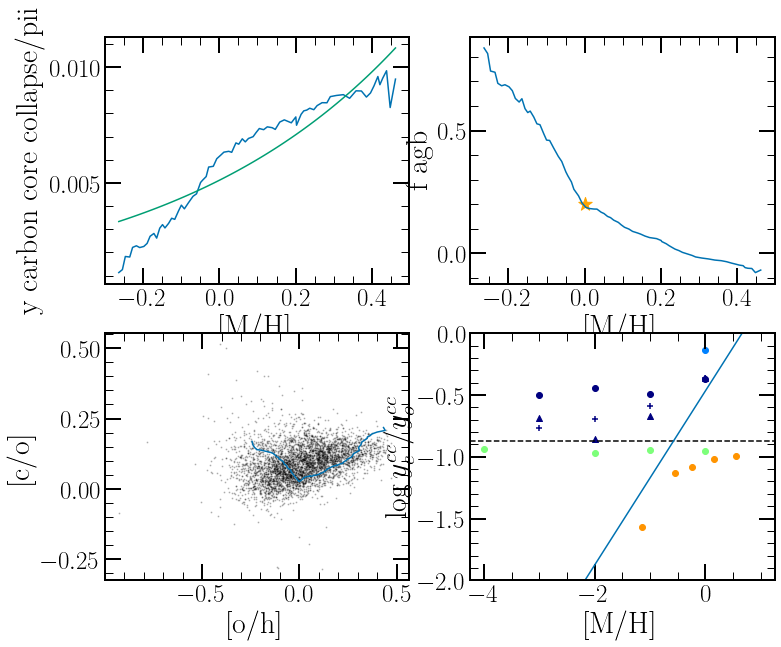

In [53]:
compare_agb_model(agb_factor=6)

model: y_c^cc = (2.8375 +- 1.71340) Z^(1.548 +- 0.0432})
model: y_c^cc = (2.8375 +- 1.71340) Z^(1.548 +- 0.0432})
model: y_c^cc = (2.8375 +- 1.71340) Z^(1.548 +- 0.0432})


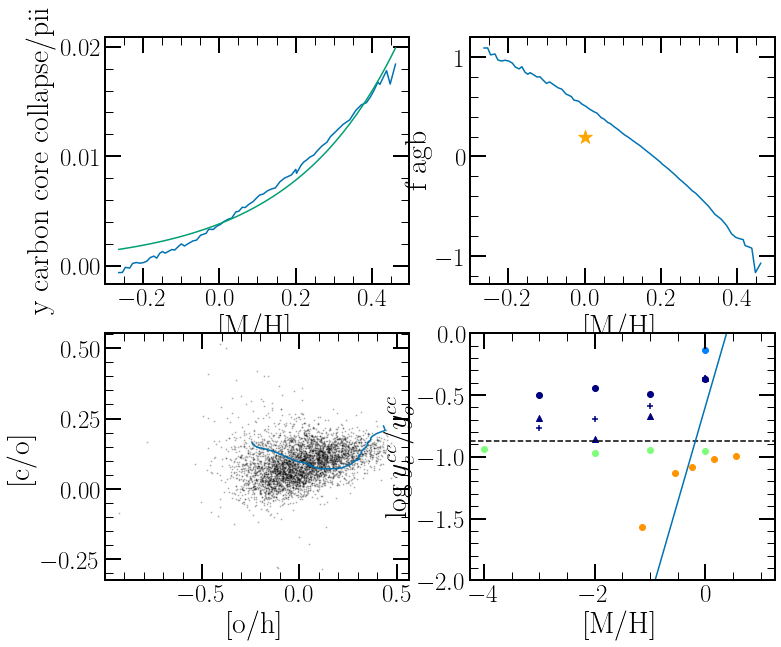

In [52]:
compare_agb_model("karakas10", agb_factor=3)

model: y_c^cc = (0.3204 +- 0.03780) Z^(0.985 +- 0.0185})
model: y_c^cc = (4.8902 +- 19.73456) Z^(1.940 +- 0.1136})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-4.101 +- 2.1392})
model: y_c^cc = (0.3204 +- 0.03780) Z^(0.985 +- 0.0185})
model: y_c^cc = (4.8902 +- 19.73456) Z^(1.940 +- 0.1136})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-4.101 +- 2.1392})
model: y_c^cc = (0.3204 +- 0.03780) Z^(0.985 +- 0.0185})
model: y_c^cc = (4.8902 +- 19.73456) Z^(1.940 +- 0.1136})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-4.101 +- 2.1392})


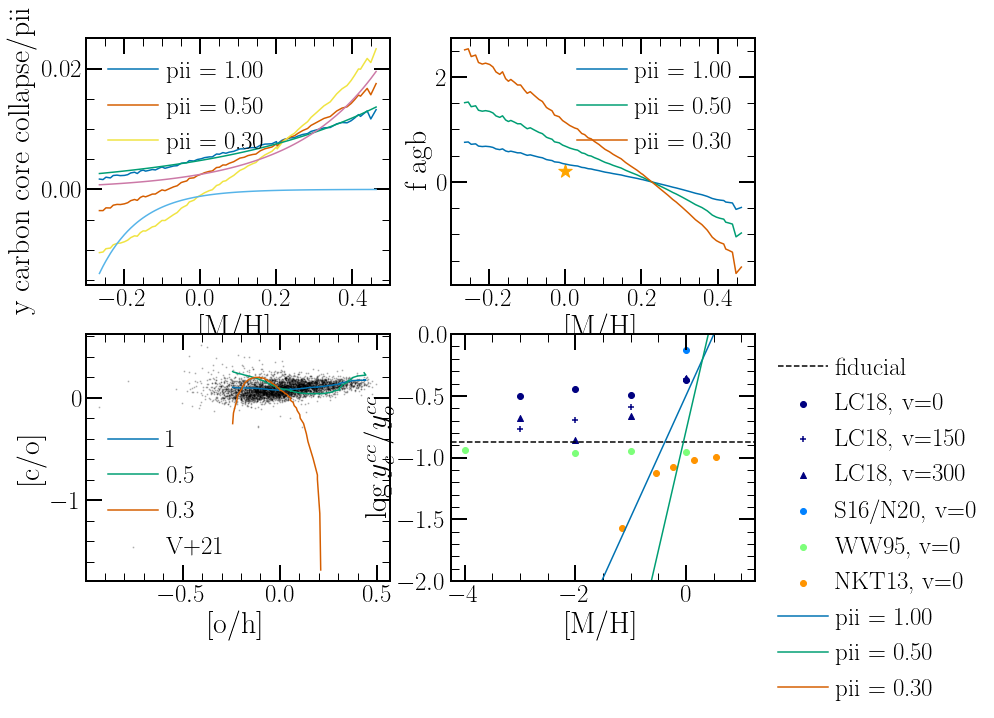

In [32]:
compare_agb_model("karakas16", agb_factor=3)

model: y_c^cc = (0.0607 +- 0.00197) Z^(0.496 +- 0.0093})
model: y_c^cc = (0.1049 +- 0.01268) Z^(0.801 +- 0.0188})
model: y_c^cc = (0.2441 +- 0.11639) Z^(1.135 +- 0.0383})
model: y_c^cc = (0.0607 +- 0.00197) Z^(0.496 +- 0.0093})
model: y_c^cc = (0.1049 +- 0.01268) Z^(0.801 +- 0.0188})
model: y_c^cc = (0.2441 +- 0.11639) Z^(1.135 +- 0.0383})
model: y_c^cc = (0.0607 +- 0.00197) Z^(0.496 +- 0.0093})
model: y_c^cc = (0.1049 +- 0.01268) Z^(0.801 +- 0.0188})
model: y_c^cc = (0.2441 +- 0.11639) Z^(1.135 +- 0.0383})


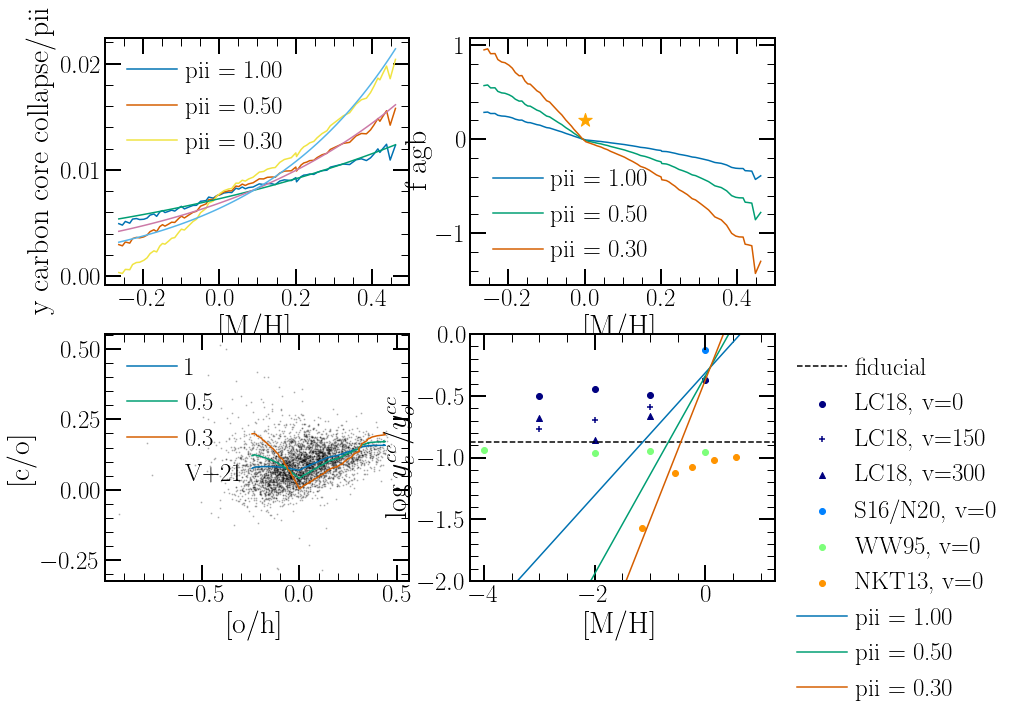

In [33]:
compare_agb_model("ventura13")

model: y_c^cc = (0.5973 +- 0.21166) Z^(1.059 +- 0.0329})
model: y_c^cc = (2.7459 +- 6.62305) Z^(1.604 +- 0.0876})
model: y_c^cc = (8.8197 +- 67.95012) Z^(2.000 +- 0.1575})
model: y_c^cc = (0.5973 +- 0.21166) Z^(1.059 +- 0.0329})
model: y_c^cc = (2.7459 +- 6.62305) Z^(1.604 +- 0.0876})
model: y_c^cc = (8.8197 +- 67.95012) Z^(2.000 +- 0.1575})
model: y_c^cc = (0.5973 +- 0.21166) Z^(1.059 +- 0.0329})
model: y_c^cc = (2.7459 +- 6.62305) Z^(1.604 +- 0.0876})
model: y_c^cc = (8.8197 +- 67.95012) Z^(2.000 +- 0.1575})


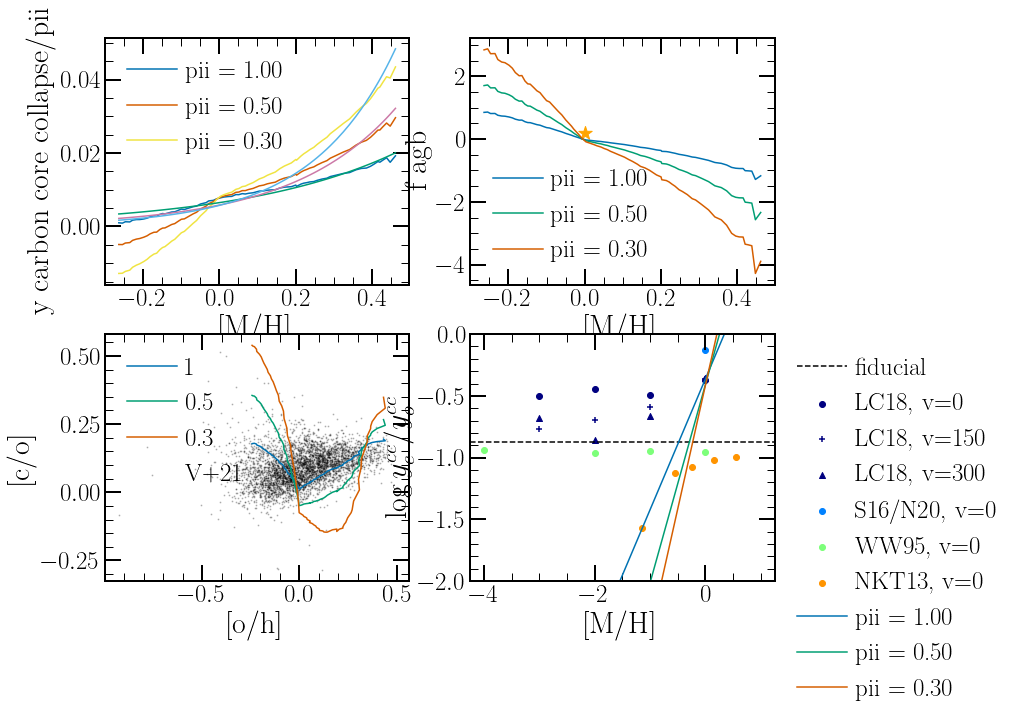

In [34]:
compare_agb_model("ventura13", agb_factor=3)

model: y_c^cc = (2.8224 +- 1.69736) Z^(1.547 +- 0.0431})
model: y_c^cc = (61.6711 +- 955.01981) Z^(2.574 +- 0.2239})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-3.548 +- 1.7001})
model: y_c^cc = (2.8224 +- 1.69736) Z^(1.547 +- 0.0431})
model: y_c^cc = (61.6711 +- 955.01981) Z^(2.574 +- 0.2239})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-3.548 +- 1.7001})
model: y_c^cc = (2.8224 +- 1.69736) Z^(1.547 +- 0.0431})
model: y_c^cc = (61.6711 +- 955.01981) Z^(2.574 +- 0.2239})
model: y_c^cc = (-0.0000 +- -0.00000) Z^(-3.548 +- 1.7001})


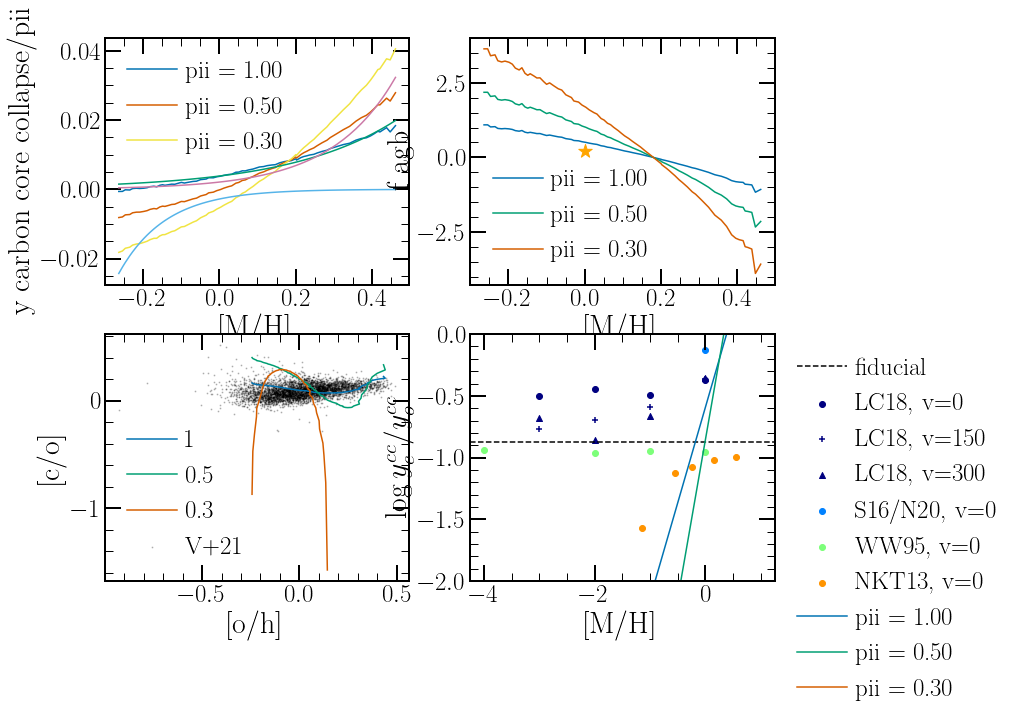

In [35]:
compare_agb_model("karakas10", agb_factor=3)

model: y_c^cc = (0.0206 +- 0.00036) Z^(0.242 +- 0.0069})
model: y_c^cc = (0.0146 +- 0.00055) Z^(0.335 +- 0.0104})
model: y_c^cc = (0.0143 +- 0.00138) Z^(0.464 +- 0.0170})
model: y_c^cc = (0.0672 +- 0.00086) Z^(0.544 +- 0.0057})
model: y_c^cc = (0.1975 +- 0.00437) Z^(1.007 +- 0.0077})
model: y_c^cc = (1.4268 +- 0.69721) Z^(1.668 +- 0.0390})
model: y_c^cc = (0.0583 +- 0.00119) Z^(0.483 +- 0.0074})
model: y_c^cc = (0.1019 +- 0.00796) Z^(0.786 +- 0.0152})
model: y_c^cc = (0.2551 +- 0.08501) Z^(1.133 +- 0.0321})
model: y_c^cc = (0.0334 +- 0.00038) Z^(0.371 +- 0.0054})
model: y_c^cc = (0.0435 +- 0.00071) Z^(0.625 +- 0.0066})
model: y_c^cc = (0.1128 +- 0.00916) Z^(1.018 +- 0.0154})


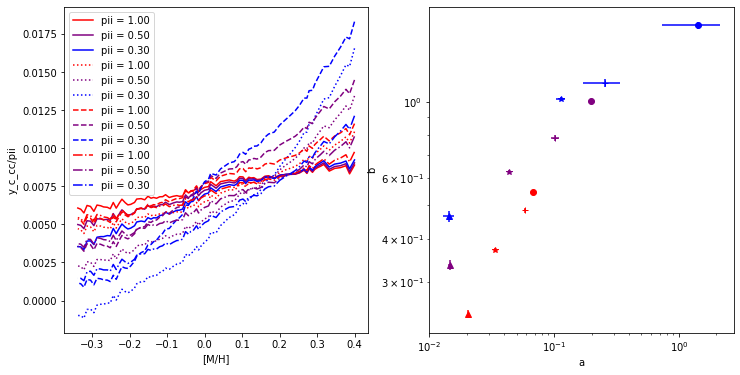

In [475]:
plt.figure(figsize=(12, 6))
for i in range(4):
    study = ["cristallo11", "karakas10", "ventura13", "karakas16"][i]
    y_agb = vice.yields.agb.interpolator("c", study=study)
    y_agb_a = np.array([y_agb_ave(i, y_agb) for i in range(len(Z))])
    

    ls = ["-", ":", "--", "-."][i]
    marker = ["^", "o", "+", "*"][i]
    for j in range(3):
        pii = [1, 0.5, 0.3][j]
        color = ["red", "purple", "blue"][j]
        
        plt.subplot(1, 2, 1)
        plot_model(y_agb_a, pii, color=color, ls=ls)
        # y_c_cc_model = fit_model(y_agb_a, pii)(Z)
        # plt.errorbar(MoverH, y_c_cc_model/pii)
        plt.legend()
        plt.xlabel("[M/H]")
        plt.ylabel("y_c_cc/pii")
        


        plt.subplot(1,2,2)

        mo = fit_model(y_agb_a, pii)
        plt.errorbar(mo.a, mo.b, xerr=mo.a_err, yerr=mo.b_err, color=color, marker=marker)
        plt.xlabel("a")
        plt.ylabel("b")
        plt.xscale("log")
        plt.yscale("log")

Left plot is every $y_c^{cc}/\varpi$ for agb, varpi values. Right plot is the fit values of the model, a is normilization and b is the slope

In [2]:
import numpy as np
import matplotlib.pyplot as plt

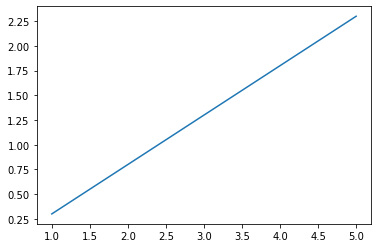

In [3]:
x = np.linspace(1, 5, 1000)
k = 0.4
pii = 0.5
y = 0.4 * (pii-1) + pii * x
plt.plot(x, y)

In [6]:
import vice
import sys

In [10]:
cd ~/surp

/home/daniel/surp


In [16]:
sys.path.append("../")

import multizone_sim

ModuleNotFoundError: No module named 'surp'

In [9]:
o = vice.output("output/fiducial")

OSError: VICE output not found: output/fiducial.vice